# Object detection on medical image
- Dataset format
- Model pipeline

In [ ]:
!pip install pydicom

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 66.0 MB/s eta 0:00:00


In [ ]:
!pip install scikit-multilearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 8.3 MB/s eta 0:00:00


In [ ]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 85.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.4-py3-none-any.whl size=39588 sha256=8ac4d2fd2a1eb1d54b573a21b531b30fb9c7332aedea84fd55a8ead7f0258aea
  Stored in directory: /root/.cache/pip/wheels/50/b0/82/1f97b5348c7fe9f0ce0ba18497202cafa5dec4562bd5292680
Successfully built grad-cam


In [ ]:
!pip install opencv-python

In [ ]:
# import libraries

# basic
import warnings
warnings.filterwarnings('ignore')

import os
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
import random
import pydicom
import itertools
import cv2
import numpy as np
import pandas as pd
import math
from tqdm.notebook import tqdm
from sklearn.preprocessing import MultiLabelBinarizer
from skmultilearn.model_selection import iterative_train_test_split
# visualization
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
# PyTorch
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection import FasterRCNN
from torchvision.transforms import v2
from torchvision import tv_tensors
from torchvision.tv_tensors import BoundingBoxes

# object detection
!pip install pycocotools
import pycocotools
from pycocotools.coco import COCO

# object detection
import json
from skimage.measure import label as sk_label
from skimage.measure import regionprops as sk_regions

import pytorch_grad_cam
from pytorch_grad_cam import EigenCAM, AblationCAM
from pytorch_grad_cam.ablation_layer import AblationLayerFasterRCNN
from pytorch_grad_cam.utils.model_targets import FasterRCNNBoxScoreTarget
from pytorch_grad_cam.utils.reshape_transforms import fasterrcnn_reshape_transform
from pytorch_grad_cam.utils.image import show_cam_on_image

為了使用 COCO API 來評估模型成效，我們會需要用到以下五個檔案

In [ ]:
!wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py
!wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py
!wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py
!wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py
!wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py

from engine import evaluate

--2024-12-30 05:02:19--  https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4063 (4.0K) [text/plain]
Saving to: ‘engine.py’

engine.py           100%[===================>]   3.97K  --.-KB/s    in 0s      

2024-12-30 05:02:19 (83.7 MB/s) - ‘engine.py’ saved [4063/4063]

--2024-12-30 05:02:19--  https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8388 (8.2K) [text/plain]
S

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

data_path = '/content/drive/MyDrive/processed_images'
print("目錄內容：", os.listdir(data_path))  # 檢查檔案是否存在

Mounted at /content/drive
目錄內容： ['train.csv', 'test.csv', 'train', 'test']


In [ ]:
## TODO: Prepare your own information
class config:

    ## roots for training & valid
    root = "/content/drive/MyDrive/processed_images/train"
    info_root = "/content/drive/MyDrive/processed_images/train"
    save_root = "/content/drive/MyDrive/working/"

    ## for test images
    test_root = "/content/drive/MyDrive/processed_images/test"
    info_root_test = "/content/drive/MyDrive/processed_images/test"

    num_classes = 8 #(for fasterrcnn: background + # of classes): 1+7=8

    batch_size = 4
    epochs = 20
    weight_decay = 1e-7
    lr = 1e-3
    momentum = 0.9 ###SGD
    seed = 42
    workers = 4
    categories = ['normal', 'aortic_curvature', 'aortic_atherosclerosis_calcification',
                  'cardiac_hypertrophy', 'intercostal_pleural_thickening', 'lung_field_infiltration',
                  'degenerative_joint_disease_of_the_thoracic_spine', 'scoliosis']
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
def seed_everything(seed):

    random.seed(seed) # Set Python random seed
    np.random.seed(seed) # Set NumPy random seed
    torch.manual_seed(seed) # Set PyTorch random seed for CPU and GPU
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    # Set PyTorch deterministic operations for cudnn backend
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


seed_everything(config.seed)

---

# Read data information

我們可以利用 `pycocotools` 這個套件來讀取 .json 檔案中的資料
## Categories

包含所有類別的 dictionary ( 不含 background ) ，每個 dictionary 中需要 2 個 key :

* `id` : 類別編號
* `name` : 類別名稱

In [ ]:
annfile = config.info_root + "/train.json"
#annfile = '/content/drive/MyDrive/train.json'
coco = COCO(annfile)   ###object(dataloader比較方便)
coco.cats

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


{1: {'id': 1, 'name': 'aortic_curvature'},
 2: {'id': 2, 'name': 'aortic_atherosclerosis_calcification'},
 3: {'id': 3, 'name': 'cardiac_hypertrophy'},
 4: {'id': 4, 'name': 'intercostal_pleural_thickening'},
 5: {'id': 5, 'name': 'lung_field_infiltration'},
 6: {'id': 6, 'name': 'degenerative_joint_disease_of_the_thoracic_spine'},
 7: {'id': 7, 'name': 'scoliosis'}}

## Images

影像相關資訊，一個 dictionary 含一張影像，內有 4 個 key :

* `file_name` : 影像路徑
* `height` : 影像高度
* `width` : 影像寬度
* `id` : 影像編號 ( unique  )

In [ ]:
coco.loadImgs(0)

[{'file_name': 'normal/220_94.jpg', 'height': 2560, 'width': 2472, 'id': 0}]

## Annotations

標註相關資訊，一個 dictionary 只包含一個 annotation ( bounding box ) ，共有 7 個 key :

* `id` : 該 annotation 的編號
* `image_id` : 該 bounding box 所屬影像的編號
* `category_id` : 該 bounding box 所屬類別的編號
* `bbox` : bounding box 的標註資訊，格式為 $[\text{xmin}, \text{ymin}, \text{width}, \text{height}]$。$\text{xmin}$ 和 $\text{ymin}$ 表示 bounding box 左上角在影像上的座標，$\text{width}$ 和 $\text{height}$ 則為 bounding box 的寬跟高
* `area` : 每個 bounding box 所圍出的面積。
* `iscrowd` : 是單一物件 ( 0 ) 或一組物件 ( 1 )。segmentation 時使用，此處直接設為 0 即可
* `segmentation` : segmentation 時使用，可忽略

In [ ]:
ann_ids = coco.getAnnIds(imgIds = 0)
coco.loadAnns(ann_ids)

[]

In [ ]:
###目前id較原本的sample多一
ann_ids = coco.getAnnIds(imgIds = 155)
coco.loadAnns(ann_ids)

[{'id': 165,
  'image_id': 155,
  'category_id': 3,
  'bbox': [816, 936, 1048, 896],
  'area': 939008,
  'iscrowd': 0,
  'segmentation': [[816, 936, 1864, 936, 1864, 1832, 816, 1832]]},
 {'id': 166,
  'image_id': 155,
  'category_id': 5,
  'bbox': [144, 336, 2008, 1941],
  'area': 3897528,
  'iscrowd': 0,
  'segmentation': [[144, 336, 2152, 336, 2152, 2277, 144, 2277]]}]

In [ ]:
del coco

---

# Data augmentation




In [ ]:
##Augmentation?No
class medTransform:
    def __init__(self, train=False):
        if train:
            self.transforms = v2.Compose(
                [
                    v2.ToImage(), ## Used while using PIL image
                    v2.ToDtype(torch.float32, scale=True),
                ]
            )
        else:
            self.transforms = v2.Compose(
                [
                    v2.ToImage(), ## Used while using PIL image
                    v2.ToDtype(torch.float32, scale=True),
                ]
            )

    def __call__(self, x, bboxes):
        if isinstance(x, torch.Tensor):
            height, width = x.shape[-2], x.shape[-1]  # (C, H, W) format
        else:  # Assuming x is a PIL Image
            width, height = x.size
        ## Loading format is COCO bboxes[x,y,w,h](吃左上XY和右下的XY)
        bboxes = tv_tensors.BoundingBoxes(bboxes, format="XYWH", canvas_size=(height,width))
        return self.transforms(x, bboxes)


---

# Dataset

在 Dataset 的部分，我們需要回傳的東西有兩項：image 和 target。

image 與先前作業沒有太大差異，只有讀取方式有所不同。至於 target 則是一個 dictionary，裡面需包含 5 個 key：

1. `boxes`：該影像中所有 bounding box 的標註，格式為 $[\text{xmin}, \text{ymin}, \text{xmax}, \text{ymax}]$。$\text{xmin}$ 和 $\text{ymin}$ 表示 bounding box 左上角在影像上的座標，$\text{xmax}$ 和 $\text{ymax}$ 則表示 bounding box 右下角在影像上的座標
2. `labels`：每個 bounding box 所對應的疾病類別
3. `image_id`：影像編號
4. `area`：每個 bounding box 所圍出的面積。
5. `iscrowd`：是單一物件 ( 0 ) 或一組物件 ( 1 )。segmentation 時使用，此處直接設為 0 即可

In [ ]:
class MedDataset(Dataset):

    def __init__(self, root, info_root, split, transforms = None):
        self.split = split
        self.root = root
        self.info_root = info_root
        self.transforms = transforms
        self.coco = COCO(os.path.join(self.info_root, f"{self.split}.json"))
        self.ids = list(sorted(self.coco.imgs.keys()))

    def get_image(self, img_id: int):
        image_path = os.path.join(self.root,self.coco.loadImgs(img_id)[0]['file_name'])
        image = Image.open(image_path).convert("RGB")
        return image

    def get_annotation(self, img_id: int):
        return self.coco.loadAnns(self.coco.getAnnIds(img_id))

    def __getitem__(self, index):
        normal = False
        img_id = self.ids[index]
        image = self.get_image(img_id)
        annotation = self.get_annotation(img_id)

        bboxes = [a['bbox']  for a in annotation]
        category_ids = [a['category_id']  for a in annotation]
        if bboxes == []:
            normal = True

        if self.transforms:
            image, bboxes = self.transforms(image, bboxes)

        def reformat_bboxes(boxes):
            return [[val[0], val[1], val[0] + val[2], val[1] + val[3]] for val in boxes]

        if normal != True:
            ## Recall that the original format is COCO
            bboxes = reformat_bboxes(bboxes)

        def create_target(bboxes, normal):
            if normal:
                return {
                    'boxes': torch.zeros((0, 4), dtype=torch.float32),  # Empty boxes
                    'labels': torch.tensor(category_ids, dtype=torch.int64),
                    'image_id': img_id,
                    'area': torch.zeros((0,), dtype=torch.float32),  # Empty areas
                    'iscrowd': torch.zeros((0,), dtype=torch.int64),  # Empty tensor for iscrowd
                }
            else:

                return {
                    'boxes': torch.tensor(bboxes),
                    'labels': torch.tensor(category_ids, dtype=torch.int64),
                    'image_id': img_id,
                    'area': torch.tensor([(bbox[2] - bbox[0]) * (bbox[3] - bbox[1]) for bbox in bboxes], dtype=torch.float32),
                    'iscrowd': torch.tensor([a['iscrowd'] for a in annotation], dtype=torch.int64)
                }

        targets = create_target(bboxes,normal)
        return image, targets

    def __len__(self):
        return len(self.ids)

## Collate_fn

用於 dataloader。由於 object detection 讀取 data 的方式與先前的 classification 和 segmentation 有所不同，因此需自定義 `collate_fn`。 <br>


In [ ]:
def collate_fn(batch: list[torch.tensor, dict]):
    return tuple(zip(*batch))

In [ ]:
def plot_image_with_boxes(image_tensor, boxes_dict):
    image_np = image_tensor.permute(1, 2, 0).numpy()
    fig, ax = plt.subplots(1)
    # Display the image
    ax.imshow(image_np)
    for box in boxes_dict['boxes']:
        # Extract coordinates (x0, y0, x1, y1)
        x0, y0, x1, y1 = box
        # Calculate the height as (y0 - y1) since y0 is the top and y1 is the bottom
        height = y1 - y0
        # Create a rectangle patch with (x0, y0) as the top-left corner
        rect = patches.Rectangle((x0, y0), x1 - x0, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    plt.show()

In [ ]:
train_dataset = MedDataset(root = config.root, info_root = config.info_root, split = "train", transforms = medTransform(train=True))
train_loader = DataLoader(train_dataset, batch_size = config.batch_size, shuffle = True,num_workers=4, collate_fn = collate_fn)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [ ]:
a,b = train_dataset.__getitem__(1)
plot_image_with_boxes(a,b)

In [ ]:
a,b = train_dataset.__getitem__(155)
print(b)
plot_image_with_boxes(a,b)

---

# Model: Faster R-CNN

這邊使用 torchvision 中內建的 Faster R-CNN 模型，並加載預訓練權重，但要記得更改 predictor 的類別數量為 8 類 ( 含 background，也就是 normal ) ，如下所示：

In [ ]:
def fasterrcnn(num_classes):
    model = models.detection.fasterrcnn_resnet50_fpn(weights='COCO_V1')
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = None
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [ ]:
model = fasterrcnn(config.num_classes)

模型架構如下：

---

# Training

在 PyTorch 的 Faster R-CNN 這個模型中，我們不須再自行定義 loss function，因為在 `model.train()` 下，`model(images, targets)` 會自動回傳訓練的 loss，其包含以下四種損失：

1. `loss_classifier`：分類器之損失
2. `loss_box_reg`：bounding box regressor 之損失
3. `loss_rpn_box_reg`：RPN 中 bounding box regressor 之損失
4. `loss_objectness`：RPN 中分類器之損失，此分類器用以判斷 bounding box 中是否包含物體

總損失為這四種 loss 的總和。

In [ ]:
def train_one_epoch(model, train_loader, optimizer, epoch, device):
    model.train()

    train_loss = []
    train_loss_dict = []

    lr_scheduler = None

    for images, targets in tqdm(train_loader):
        images = [image.to(device) for image in images]
        targets = [{k: (torch.tensor(v,device=device) if not isinstance(v, torch.Tensor) else v.to(device)) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        batch_loss_value = losses.item()
        batch_loss_dict = {k: v.item() for k, v in loss_dict.items()}

        train_loss.append(batch_loss_value)
        train_loss_dict.append(batch_loss_dict)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

    train_loss = np.mean(train_loss)
    train_loss_dict = pd.DataFrame(train_loss_dict).mean()
    train_loss_classifier = train_loss_dict.loss_classifier
    train_loss_box_reg = train_loss_dict.loss_box_reg
    train_loss_rpn_box_reg = train_loss_dict.loss_rpn_box_reg
    train_loss_objectness = train_loss_dict.loss_objectness

    return train_loss, train_loss_classifier, train_loss_box_reg, train_loss_rpn_box_reg, train_loss_objectness

---

# Validation

在此模型中，若設定 `model.eval()`，只會返回預測的 bounding box、confidence score 和該 bounding box 的 label。

為了取得 validation set 的 loss 以選出最好的模型，這裡我在進行 validation 時使用 `model.train()`。如果要這麼做，需要把模型中的 batch normalization 和 dropout 的係數固定住，但因 Faster R-CNN 中不含 dropout 層，所以只需凍結 batch normalization 層的參數。

In [ ]:
def validation(model, val_loader, device):
    model.train()
    #model.eval()
    for m in model.modules():
        if isinstance(m, torchvision.ops.Conv2dNormActivation):
            m.eval()
        if isinstance(m, torchvision.ops.FrozenBatchNorm2d):
            m.eval()
        if isinstance(m, torch.nn.BatchNorm2d):
            m.eval()
    val_loss = []
    val_loss_dict = []
    with torch.no_grad():
        for images, targets in tqdm(val_loader):
            images = [image.to(device) for image in images]
            targets = [{k: (torch.tensor(v,device=device) if not isinstance(v, torch.Tensor) else v.to(device)) for k, v in t.items()} for t in targets]

            loss = model(images, targets)
            total_loss = sum(l for l in loss.values())

            loss_value = total_loss.item()
            loss_dict = {k: v.item() for k, v in loss.items()}

            val_loss.append(loss_value)
            val_loss_dict.append(loss_dict)

    val_loss = np.mean(val_loss)

    val_loss_dict = pd.DataFrame(val_loss_dict).mean()
    val_loss_classifier = val_loss_dict.loss_classifier
    val_loss_box_reg = val_loss_dict.loss_box_reg
    val_loss_rpn_box_reg = val_loss_dict.loss_rpn_box_reg
    val_loss_objectness = val_loss_dict.loss_objectness

    return val_loss, val_loss_classifier, val_loss_box_reg, val_loss_rpn_box_reg, val_loss_objectness

In [ ]:
del model
del train_dataset, train_loader

In [ ]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

---

# Main

##SGD batch size=8

In [ ]:
def train_one_epoch(model, train_loader, optimizer, epoch, device):
    model.train()

    train_loss = []
    train_loss_dict = []

    lr_scheduler = None

    for images, targets in tqdm(train_loader):
        images = [image.to(device) for image in images]
        targets = [{k: (torch.tensor(v,device=device) if not isinstance(v, torch.Tensor) else v.to(device)) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        batch_loss_value = losses.item()
        batch_loss_dict = {k: v.item() for k, v in loss_dict.items()}

        train_loss.append(batch_loss_value)
        train_loss_dict.append(batch_loss_dict)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

    train_loss = np.mean(train_loss)
    train_loss_dict = pd.DataFrame(train_loss_dict).mean()
    train_loss_classifier = train_loss_dict.loss_classifier
    train_loss_box_reg = train_loss_dict.loss_box_reg
    train_loss_rpn_box_reg = train_loss_dict.loss_rpn_box_reg
    train_loss_objectness = train_loss_dict.loss_objectness

    return train_loss, train_loss_classifier, train_loss_box_reg, train_loss_rpn_box_reg, train_loss_objectness

In [ ]:
def main():

    seed_everything(config.seed)
    g = torch.Generator()
    g.manual_seed(config.seed)

    train_dataset = MedDataset(root = config.root, info_root = config.info_root, split = "train", transforms = medTransform(train=True))
    val_dataset = MedDataset(root = config.root, info_root = config.info_root, split = "val",  transforms = medTransform(train=False))

    train_loader = DataLoader(train_dataset, batch_size = config.batch_size, shuffle = True,
                              num_workers=config.workers, collate_fn = collate_fn,pin_memory=True
                             )
    val_loader = DataLoader(val_dataset, batch_size = config.batch_size, shuffle = False,
                            num_workers=config.workers, worker_init_fn=seed_worker,
                            generator=g, collate_fn = collate_fn,pin_memory=True
                           )


    device = config.device
    model =  fasterrcnn(num_classes = config.num_classes)
    model.to(device)

    parameters = [p for p in model.parameters() if p.requires_grad]

    optimizer = torch.optim.SGD(parameters, lr = config.lr, momentum = config.momentum, nesterov = True, weight_decay = config.weight_decay)

    #scheduler = CosineAnnealingLR(optimizer, T_max=config.epochs, eta_min=0)

    best_val_loss = float("inf")
    best_map50 = 0.0
    history = {
        "train": {
            "loss": [],
            "loss_classifier": [],
            "loss_box_reg": [],
            "loss_rpn_box_reg": [],
            "loss_objectness": []
        },
        "val": {
            "loss": [],
            "loss_classifier": [],
            "loss_box_reg": [],
            "loss_rpn_box_reg": [],
            "loss_objectness": []
        },
        "map50":{
            "train":[],
            "valid":[],
        }
    }
    best_idx = 0
    print('start')
    for epoch in range(config.epochs):
        print()
        train_loss, train_loss_classifier, train_loss_box_reg, train_loss_rpn_box_reg, train_loss_objectness = train_one_epoch(
            model, train_loader, optimizer, epoch, device,
        )

        val_loss, val_loss_classifier, val_loss_box_reg, val_loss_rpn_box_reg, val_loss_objectness = validation(
            model, val_loader, device
        )

        ## Training
        history["train"]["loss"].append(train_loss)
        history["train"]["loss_classifier"].append(train_loss_classifier)
        history["train"]["loss_box_reg"].append(train_loss_box_reg)
        history["train"]["loss_rpn_box_reg"].append(train_loss_rpn_box_reg)
        history["train"]["loss_objectness"].append(train_loss_objectness)
        ## Validation
        history["val"]["loss"].append(val_loss)
        history["val"]["loss_classifier"].append(val_loss_classifier)
        history["val"]["loss_box_reg"].append(val_loss_box_reg)
        history["val"]["loss_rpn_box_reg"].append(val_loss_rpn_box_reg)
        history["val"]["loss_objectness"].append(val_loss_objectness)


        print(f'Epoch: {epoch+1}/{config.epochs} | LR: {optimizer.state_dict()["param_groups"][0]["lr"]:.6f}')

        print("*****Training*****")
        print(f'Loss: {train_loss:.4f} | Classifier Loss: {train_loss_classifier:.4f} | Box Reg Loss: {train_loss_box_reg:.4f} | RPN Box Reg Loss: {train_loss_rpn_box_reg:.4f} | Objectness Loss: {train_loss_objectness:.4f}')
        train_evaluator = evaluate(model, train_loader, device = device)
        print("*****Validation*****")
        print(f'Loss: {val_loss:.4f} | Classifier Loss: {val_loss_classifier:.4f} | Box Reg Loss: {val_loss_box_reg:.4f} | RPN Box Reg Loss: {val_loss_rpn_box_reg:.4f} | Objectness Loss: {val_loss_objectness:.4f}')
        valid_evaluator = evaluate(model, val_loader, device = device)

        train_map50 = train_evaluator.coco_eval['bbox'].stats[1]
        valid_map50 = valid_evaluator.coco_eval['bbox'].stats[1]
        print("*****Training*****")
        print(f'MAP: {train_map50:.4f}')
        print("*****Validationg*****")
        print(f'MAP: {valid_map50:.4f}')
        history["map50"]["train"].append(train_map50)
        history["map50"]["valid"].append(valid_map50)

        ## TODO save your model

        if valid_map50 > best_map50:
            save_file = {
                "model": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "epoch": epoch,
                "args": config
            }
            best_idx=epoch
            best_map50 = valid_map50
            torch.save(save_file, os.path.join(config.save_root,"final.pth"))
        #scheduler.step()
    print(f'Best epoch in {best_idx+1}')


    ## Evaluation result
    plt.figure(figsize = (12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(config.epochs), history["map50"]["train"], label = 'Training map50')
    plt.plot(range(config.epochs), history["map50"]["valid"], label = 'Validation map50')
    plt.xlabel('Epoch')
    plt.ylabel('map')
    plt.legend()
    plt.title('Training and Validation map50')
    plt.show()

    plt.figure(figsize = (12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(config.epochs), history["train"]["loss"], label = 'Training Loss')
    plt.plot(range(config.epochs), history["val"]["loss"], label = 'Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss Curves')
    plt.show()

    plt.figure(figsize = (12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(config.epochs), history["train"]["loss_classifier"], label = 'Training Classifier Loss')
    plt.plot(range(config.epochs), history["val"]["loss_classifier"], label = 'Validation Classifier Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Classifier Loss')
    plt.legend()
    plt.title('Training and Validation Classifier Loss Curves')
    plt.show()

    plt.figure(figsize = (12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(config.epochs), history["train"]["loss_box_reg"], label = 'Training Box Reg Loss')
    plt.plot(range(config.epochs), history["val"]["loss_box_reg"], label = 'Validation Box Reg Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Box Reg Loss')
    plt.legend()
    plt.title('Training and Validation Box Reg Loss Curves')
    plt.show()

    plt.figure(figsize = (12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(config.epochs), history["train"]["loss_rpn_box_reg"], label = 'Training RPN Box Reg Loss')
    plt.plot(range(config.epochs), history["val"]["loss_rpn_box_reg"], label = 'Validation RPN Box Reg Loss')

    plt.xlabel('Epoch')
    plt.ylabel('RPN Box Reg Loss')
    plt.legend()
    plt.title('Training and Validation RPN Box Reg Loss Curves')
    plt.show()

    plt.figure(figsize = (12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(config.epochs), history["train"]["loss_objectness"], label = 'Training Objectness Loss')
    plt.plot(range(config.epochs), history["val"]["loss_objectness"], label = 'Validation Objectness Loss')

    plt.xlabel('Epoch')
    plt.ylabel('Objectness Loss')
    plt.legend()
    plt.title('Training and Validation Objectness Loss Curves')
    plt.show()


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
start



  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1/20 | LR: 0.001000
*****Training*****
Loss: 0.4064 | Classifier Loss: 0.2827 | Box Reg Loss: 0.0945 | RPN Box Reg Loss: 0.0096 | Objectness Loss: 0.0197
creating index...
index created!
Test:  [ 0/35]  eta: 0:01:38  model_time: 0.4251 (0.4251)  evaluator_time: 0.0251 (0.0251)  time: 2.8075  data: 2.3102  max mem: 9591
Test:  [34/35]  eta: 0:00:00  model_time: 0.4136 (0.4146)  evaluator_time: 0.0108 (0.0123)  time: 0.4644  data: 0.0004  max mem: 9591
Test: Total time: 0:00:18 (0.5384 s / it)
Averaged stats: model_time: 0.4136 (0.4146)  evaluator_time: 0.0108 (0.0123)
Accumulating evaluation results...
DONE (t=0.14s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.007
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.033
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ Io

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 2/20 | LR: 0.001000
*****Training*****
Loss: 0.2366 | Classifier Loss: 0.1184 | Box Reg Loss: 0.0998 | RPN Box Reg Loss: 0.0087 | Objectness Loss: 0.0097
creating index...
index created!
Test:  [ 0/35]  eta: 0:01:31  model_time: 0.4098 (0.4098)  evaluator_time: 0.0207 (0.0207)  time: 2.6037  data: 2.1260  max mem: 9591
Test:  [34/35]  eta: 0:00:00  model_time: 0.4070 (0.4137)  evaluator_time: 0.0152 (0.0153)  time: 0.4597  data: 0.0004  max mem: 9591
Test: Total time: 0:00:18 (0.5353 s / it)
Averaged stats: model_time: 0.4070 (0.4137)  evaluator_time: 0.0152 (0.0153)
Accumulating evaluation results...
DONE (t=0.20s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.016
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.064
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ Io

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 3/20 | LR: 0.001000
*****Training*****
Loss: 0.2256 | Classifier Loss: 0.1110 | Box Reg Loss: 0.0983 | RPN Box Reg Loss: 0.0087 | Objectness Loss: 0.0075
creating index...
index created!
Test:  [ 0/35]  eta: 0:01:31  model_time: 0.4049 (0.4049)  evaluator_time: 0.0253 (0.0253)  time: 2.6173  data: 2.1406  max mem: 9591
Test:  [34/35]  eta: 0:00:00  model_time: 0.4197 (0.4145)  evaluator_time: 0.0139 (0.0229)  time: 0.4695  data: 0.0004  max mem: 9591
Test: Total time: 0:00:19 (0.5440 s / it)
Averaged stats: model_time: 0.4197 (0.4145)  evaluator_time: 0.0139 (0.0229)
Accumulating evaluation results...
DONE (t=0.18s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.030
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.113
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.005
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ Io

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 4/20 | LR: 0.001000
*****Training*****
Loss: 0.2152 | Classifier Loss: 0.1039 | Box Reg Loss: 0.0973 | RPN Box Reg Loss: 0.0073 | Objectness Loss: 0.0067
creating index...
index created!
Test:  [ 0/35]  eta: 0:01:38  model_time: 0.4427 (0.4427)  evaluator_time: 0.0303 (0.0303)  time: 2.8032  data: 2.2840  max mem: 9591
Test:  [34/35]  eta: 0:00:00  model_time: 0.4105 (0.4086)  evaluator_time: 0.0141 (0.0154)  time: 0.4588  data: 0.0004  max mem: 9591
Test: Total time: 0:00:18 (0.5349 s / it)
Averaged stats: model_time: 0.4105 (0.4086)  evaluator_time: 0.0141 (0.0154)
Accumulating evaluation results...
DONE (t=0.19s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.058
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.180
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.019
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ Io

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 5/20 | LR: 0.001000
*****Training*****
Loss: 0.2089 | Classifier Loss: 0.0994 | Box Reg Loss: 0.0966 | RPN Box Reg Loss: 0.0068 | Objectness Loss: 0.0060
creating index...
index created!
Test:  [ 0/35]  eta: 0:01:17  model_time: 0.4386 (0.4386)  evaluator_time: 0.0280 (0.0280)  time: 2.2187  data: 1.7087  max mem: 9591
Test:  [34/35]  eta: 0:00:00  model_time: 0.4103 (0.4116)  evaluator_time: 0.0145 (0.0243)  time: 0.4779  data: 0.0003  max mem: 9591
Test: Total time: 0:00:18 (0.5301 s / it)
Averaged stats: model_time: 0.4103 (0.4116)  evaluator_time: 0.0145 (0.0243)
Accumulating evaluation results...
DONE (t=0.19s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.088
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.224
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.049
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ Io

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 6/20 | LR: 0.001000
*****Training*****
Loss: 0.2029 | Classifier Loss: 0.0949 | Box Reg Loss: 0.0965 | RPN Box Reg Loss: 0.0063 | Objectness Loss: 0.0051
creating index...
index created!
Test:  [ 0/35]  eta: 0:01:17  model_time: 0.4222 (0.4222)  evaluator_time: 0.0306 (0.0306)  time: 2.2274  data: 1.7349  max mem: 9591
Test:  [34/35]  eta: 0:00:00  model_time: 0.4242 (0.4083)  evaluator_time: 0.0139 (0.0162)  time: 0.4633  data: 0.0004  max mem: 9591
Test: Total time: 0:00:18 (0.5284 s / it)
Averaged stats: model_time: 0.4242 (0.4083)  evaluator_time: 0.0139 (0.0162)
Accumulating evaluation results...
DONE (t=0.20s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.099
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.230
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.063
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ Io

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 7/20 | LR: 0.001000
*****Training*****
Loss: 0.1948 | Classifier Loss: 0.0892 | Box Reg Loss: 0.0946 | RPN Box Reg Loss: 0.0061 | Objectness Loss: 0.0049
creating index...
index created!
Test:  [ 0/35]  eta: 0:01:27  model_time: 0.5062 (0.5062)  evaluator_time: 0.0250 (0.0250)  time: 2.5022  data: 1.9268  max mem: 9591
Test:  [34/35]  eta: 0:00:00  model_time: 0.3999 (0.4085)  evaluator_time: 0.0148 (0.0158)  time: 0.4539  data: 0.0004  max mem: 9591
Test: Total time: 0:00:18 (0.5247 s / it)
Averaged stats: model_time: 0.3999 (0.4085)  evaluator_time: 0.0148 (0.0158)
Accumulating evaluation results...
DONE (t=0.20s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.109
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.240
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.076
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ Io

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 8/20 | LR: 0.001000
*****Training*****
Loss: 0.1907 | Classifier Loss: 0.0861 | Box Reg Loss: 0.0939 | RPN Box Reg Loss: 0.0059 | Objectness Loss: 0.0049
creating index...
index created!
Test:  [ 0/35]  eta: 0:01:31  model_time: 0.4794 (0.4794)  evaluator_time: 0.0308 (0.0308)  time: 2.6206  data: 2.0643  max mem: 9591
Test:  [34/35]  eta: 0:00:00  model_time: 0.4016 (0.4090)  evaluator_time: 0.0157 (0.0168)  time: 0.4561  data: 0.0005  max mem: 9591
Test: Total time: 0:00:18 (0.5303 s / it)
Averaged stats: model_time: 0.4016 (0.4090)  evaluator_time: 0.0157 (0.0168)
Accumulating evaluation results...
DONE (t=0.20s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.125
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.284
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.078
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ Io

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 9/20 | LR: 0.001000
*****Training*****
Loss: 0.1742 | Classifier Loss: 0.0780 | Box Reg Loss: 0.0859 | RPN Box Reg Loss: 0.0057 | Objectness Loss: 0.0045
creating index...
index created!
Test:  [ 0/35]  eta: 0:01:36  model_time: 0.4264 (0.4264)  evaluator_time: 0.0274 (0.0274)  time: 2.7453  data: 2.2490  max mem: 9591
Test:  [34/35]  eta: 0:00:00  model_time: 0.4119 (0.4109)  evaluator_time: 0.0145 (0.0157)  time: 0.4583  data: 0.0004  max mem: 9591
Test: Total time: 0:00:18 (0.5364 s / it)
Averaged stats: model_time: 0.4119 (0.4109)  evaluator_time: 0.0145 (0.0157)
Accumulating evaluation results...
DONE (t=0.20s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.155
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.337
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.106
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ Io

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 10/20 | LR: 0.001000
*****Training*****
Loss: 0.1707 | Classifier Loss: 0.0770 | Box Reg Loss: 0.0834 | RPN Box Reg Loss: 0.0056 | Objectness Loss: 0.0047
creating index...
index created!
Test:  [ 0/35]  eta: 0:01:20  model_time: 0.4411 (0.4411)  evaluator_time: 0.0433 (0.0433)  time: 2.2964  data: 1.7674  max mem: 9591
Test:  [34/35]  eta: 0:00:00  model_time: 0.4079 (0.4099)  evaluator_time: 0.0139 (0.0163)  time: 0.4590  data: 0.0003  max mem: 9591
Test: Total time: 0:00:18 (0.5400 s / it)
Averaged stats: model_time: 0.4079 (0.4099)  evaluator_time: 0.0139 (0.0163)
Accumulating evaluation results...
DONE (t=0.20s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.169
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.363
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.138
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ I

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 11/20 | LR: 0.001000
*****Training*****
Loss: 0.1606 | Classifier Loss: 0.0745 | Box Reg Loss: 0.0769 | RPN Box Reg Loss: 0.0055 | Objectness Loss: 0.0037
creating index...
index created!
Test:  [ 0/35]  eta: 0:01:31  model_time: 0.4200 (0.4200)  evaluator_time: 0.0233 (0.0233)  time: 2.6003  data: 2.1101  max mem: 9591
Test:  [34/35]  eta: 0:00:00  model_time: 0.4040 (0.4048)  evaluator_time: 0.0130 (0.0144)  time: 0.4510  data: 0.0003  max mem: 9591
Test: Total time: 0:00:18 (0.5248 s / it)
Averaged stats: model_time: 0.4040 (0.4048)  evaluator_time: 0.0130 (0.0144)
Accumulating evaluation results...
DONE (t=0.17s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.189
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.387
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.149
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ I

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 12/20 | LR: 0.001000
*****Training*****
Loss: 0.1505 | Classifier Loss: 0.0713 | Box Reg Loss: 0.0707 | RPN Box Reg Loss: 0.0052 | Objectness Loss: 0.0032
creating index...
index created!
Test:  [ 0/35]  eta: 0:01:45  model_time: 0.4214 (0.4214)  evaluator_time: 0.0247 (0.0247)  time: 3.0144  data: 2.5235  max mem: 9591
Test:  [34/35]  eta: 0:00:00  model_time: 0.4077 (0.4056)  evaluator_time: 0.0121 (0.0225)  time: 0.4706  data: 0.0004  max mem: 9591
Test: Total time: 0:00:19 (0.5457 s / it)
Averaged stats: model_time: 0.4077 (0.4056)  evaluator_time: 0.0121 (0.0225)
Accumulating evaluation results...
DONE (t=0.15s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.206
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.398
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.187
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ I

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 13/20 | LR: 0.001000
*****Training*****
Loss: 0.1438 | Classifier Loss: 0.0693 | Box Reg Loss: 0.0656 | RPN Box Reg Loss: 0.0052 | Objectness Loss: 0.0037
creating index...
index created!
Test:  [ 0/35]  eta: 0:01:19  model_time: 0.4426 (0.4426)  evaluator_time: 0.0383 (0.0383)  time: 2.2611  data: 1.7359  max mem: 9591
Test:  [34/35]  eta: 0:00:00  model_time: 0.4077 (0.4068)  evaluator_time: 0.0131 (0.0152)  time: 0.4555  data: 0.0004  max mem: 9591
Test: Total time: 0:00:18 (0.5187 s / it)
Averaged stats: model_time: 0.4077 (0.4068)  evaluator_time: 0.0131 (0.0152)
Accumulating evaluation results...
DONE (t=0.18s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.206
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.418
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.166
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ I

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 14/20 | LR: 0.001000
*****Training*****
Loss: 0.1421 | Classifier Loss: 0.0694 | Box Reg Loss: 0.0646 | RPN Box Reg Loss: 0.0050 | Objectness Loss: 0.0032
creating index...
index created!
Test:  [ 0/35]  eta: 0:01:47  model_time: 0.4336 (0.4336)  evaluator_time: 0.0199 (0.0199)  time: 3.0785  data: 2.5803  max mem: 9591
Test:  [34/35]  eta: 0:00:00  model_time: 0.4087 (0.4057)  evaluator_time: 0.0120 (0.0128)  time: 0.4534  data: 0.0004  max mem: 9591
Test: Total time: 0:00:18 (0.5379 s / it)
Averaged stats: model_time: 0.4087 (0.4057)  evaluator_time: 0.0120 (0.0128)
Accumulating evaluation results...
DONE (t=0.16s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.250
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.464
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.241
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ I

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 15/20 | LR: 0.001000
*****Training*****
Loss: 0.1352 | Classifier Loss: 0.0660 | Box Reg Loss: 0.0612 | RPN Box Reg Loss: 0.0051 | Objectness Loss: 0.0028
creating index...
index created!
Test:  [ 0/35]  eta: 0:01:25  model_time: 0.4182 (0.4182)  evaluator_time: 0.0241 (0.0241)  time: 2.4294  data: 1.9440  max mem: 9591
Test:  [34/35]  eta: 0:00:00  model_time: 0.4085 (0.4046)  evaluator_time: 0.0121 (0.0221)  time: 0.4699  data: 0.0004  max mem: 9591
Test: Total time: 0:00:18 (0.5279 s / it)
Averaged stats: model_time: 0.4085 (0.4046)  evaluator_time: 0.0121 (0.0221)
Accumulating evaluation results...
DONE (t=0.16s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.244
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.472
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.206
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ I

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 16/20 | LR: 0.001000
*****Training*****
Loss: 0.1311 | Classifier Loss: 0.0650 | Box Reg Loss: 0.0591 | RPN Box Reg Loss: 0.0049 | Objectness Loss: 0.0021
creating index...
index created!
Test:  [ 0/35]  eta: 0:01:46  model_time: 0.4368 (0.4368)  evaluator_time: 0.0230 (0.0230)  time: 3.0570  data: 2.5510  max mem: 9591
Test:  [34/35]  eta: 0:00:00  model_time: 0.4207 (0.4032)  evaluator_time: 0.0114 (0.0134)  time: 0.4521  data: 0.0004  max mem: 9591
Test: Total time: 0:00:18 (0.5353 s / it)
Averaged stats: model_time: 0.4207 (0.4032)  evaluator_time: 0.0114 (0.0134)
Accumulating evaluation results...
DONE (t=0.15s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.285
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.492
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.294
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ I

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 17/20 | LR: 0.001000
*****Training*****
Loss: 0.1284 | Classifier Loss: 0.0638 | Box Reg Loss: 0.0572 | RPN Box Reg Loss: 0.0048 | Objectness Loss: 0.0025
creating index...
index created!
Test:  [ 0/35]  eta: 0:01:17  model_time: 0.3977 (0.3977)  evaluator_time: 0.0277 (0.0277)  time: 2.2099  data: 1.7399  max mem: 9591
Test:  [34/35]  eta: 0:00:00  model_time: 0.4168 (0.4080)  evaluator_time: 0.0112 (0.0125)  time: 0.4618  data: 0.0004  max mem: 9591
Test: Total time: 0:00:18 (0.5174 s / it)
Averaged stats: model_time: 0.4168 (0.4080)  evaluator_time: 0.0112 (0.0125)
Accumulating evaluation results...
DONE (t=0.14s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.286
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.499
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.284
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ I

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 18/20 | LR: 0.001000
*****Training*****
Loss: 0.1286 | Classifier Loss: 0.0640 | Box Reg Loss: 0.0575 | RPN Box Reg Loss: 0.0046 | Objectness Loss: 0.0024
creating index...
index created!
Test:  [ 0/35]  eta: 0:01:16  model_time: 0.4270 (0.4270)  evaluator_time: 0.0241 (0.0241)  time: 2.1902  data: 1.6969  max mem: 9591
Test:  [34/35]  eta: 0:00:00  model_time: 0.4083 (0.4052)  evaluator_time: 0.0119 (0.0222)  time: 0.4469  data: 0.0003  max mem: 9591
Test: Total time: 0:00:18 (0.5213 s / it)
Averaged stats: model_time: 0.4083 (0.4052)  evaluator_time: 0.0119 (0.0222)
Accumulating evaluation results...
DONE (t=0.15s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.305
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.525
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.304
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ I

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 19/20 | LR: 0.001000
*****Training*****
Loss: 0.1237 | Classifier Loss: 0.0625 | Box Reg Loss: 0.0545 | RPN Box Reg Loss: 0.0045 | Objectness Loss: 0.0022
creating index...
index created!
Test:  [ 0/35]  eta: 0:01:40  model_time: 0.4129 (0.4129)  evaluator_time: 0.0258 (0.0258)  time: 2.8828  data: 2.4006  max mem: 9591
Test:  [34/35]  eta: 0:00:00  model_time: 0.4028 (0.4054)  evaluator_time: 0.0118 (0.0130)  time: 0.4506  data: 0.0004  max mem: 9591
Test: Total time: 0:00:18 (0.5324 s / it)
Averaged stats: model_time: 0.4028 (0.4054)  evaluator_time: 0.0118 (0.0130)
Accumulating evaluation results...
DONE (t=0.14s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.318
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.549
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.318
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ I

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 20/20 | LR: 0.001000
*****Training*****
Loss: 0.1213 | Classifier Loss: 0.0604 | Box Reg Loss: 0.0536 | RPN Box Reg Loss: 0.0046 | Objectness Loss: 0.0026
creating index...
index created!
Test:  [ 0/35]  eta: 0:01:23  model_time: 0.4072 (0.4072)  evaluator_time: 0.0239 (0.0239)  time: 2.3742  data: 1.8987  max mem: 9591
Test:  [34/35]  eta: 0:00:00  model_time: 0.4059 (0.4034)  evaluator_time: 0.0116 (0.0121)  time: 0.4490  data: 0.0003  max mem: 9591
Test: Total time: 0:00:18 (0.5204 s / it)
Averaged stats: model_time: 0.4059 (0.4034)  evaluator_time: 0.0116 (0.0121)
Accumulating evaluation results...
DONE (t=0.14s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.325
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.562
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.331
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ I

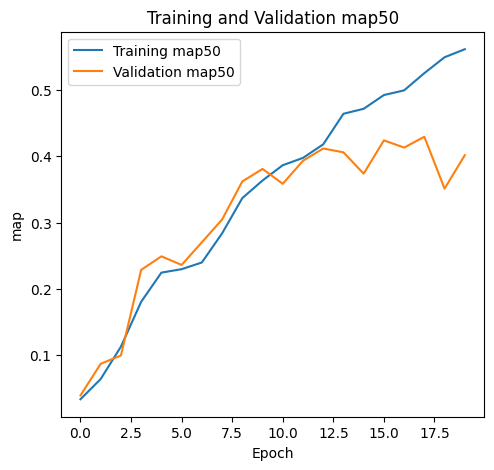

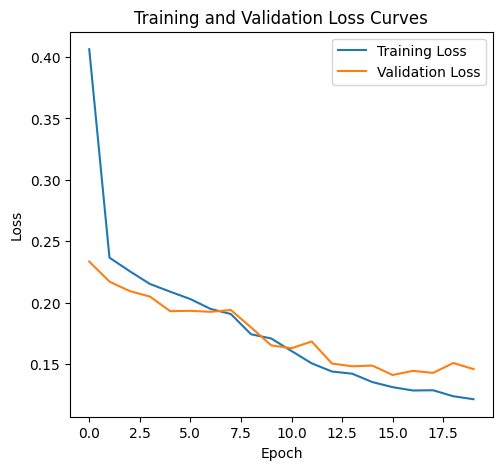

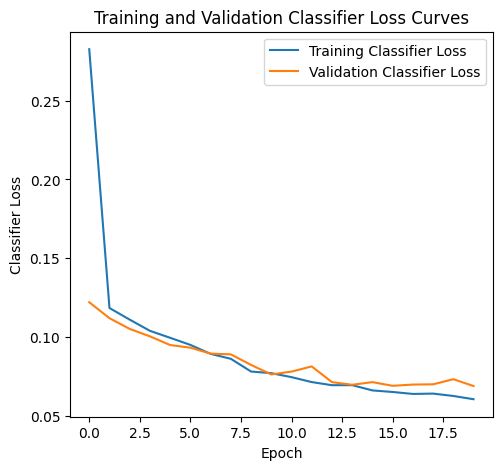

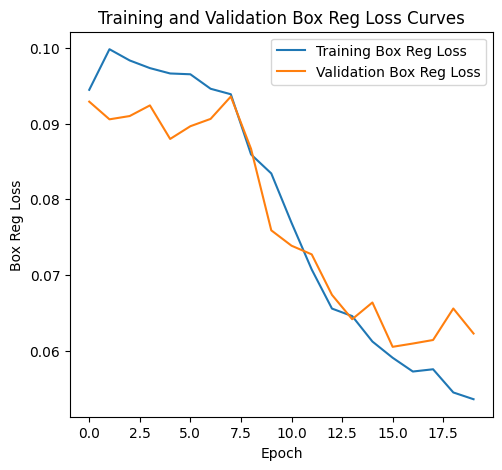

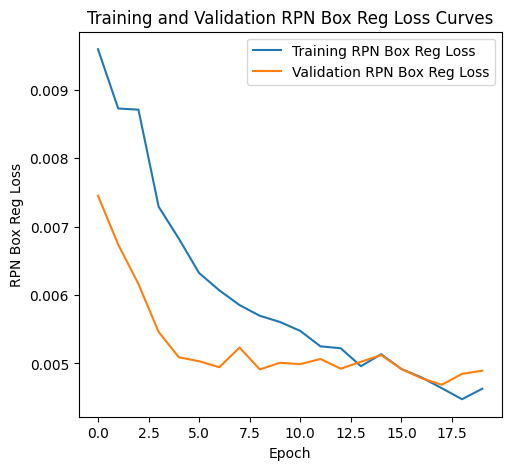

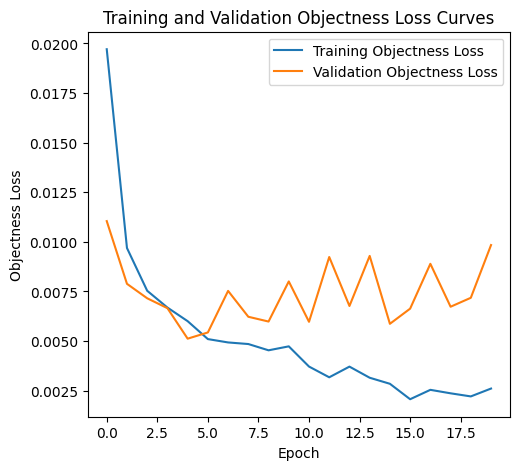

In [ ]:
## IMAGENET 3
if __name__ == "__main__":
    main()

##AdamW+Onecycle

In [ ]:
def train_one_epoch(model, train_loader, optimizer, lr_scheduler,  epoch, device):
    model.train()

    train_loss = []
    train_loss_dict = []

    #lr_scheduler = None

    for images, targets in tqdm(train_loader):
        images = [image.to(device) for image in images]
        targets = [{k: (torch.tensor(v,device=device) if not isinstance(v, torch.Tensor) else v.to(device)) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        batch_loss_value = losses.item()
        batch_loss_dict = {k: v.item() for k, v in loss_dict.items()}

        train_loss.append(batch_loss_value)
        train_loss_dict.append(batch_loss_dict)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

    train_loss = np.mean(train_loss)
    train_loss_dict = pd.DataFrame(train_loss_dict).mean()
    train_loss_classifier = train_loss_dict.loss_classifier
    train_loss_box_reg = train_loss_dict.loss_box_reg
    train_loss_rpn_box_reg = train_loss_dict.loss_rpn_box_reg
    train_loss_objectness = train_loss_dict.loss_objectness

    return train_loss, train_loss_classifier, train_loss_box_reg, train_loss_rpn_box_reg, train_loss_objectness

In [ ]:
##AdamW OneSample
def main():

    seed_everything(config.seed)
    g = torch.Generator()
    g.manual_seed(config.seed)

    train_dataset = MedDataset(root = config.root, info_root = config.info_root, split = "train", transforms = medTransform(train=True))
    val_dataset = MedDataset(root = config.root, info_root = config.info_root, split = "val",  transforms = medTransform(train=False))

    train_loader = DataLoader(train_dataset, batch_size = config.batch_size, shuffle = True,
                              num_workers=config.workers, collate_fn = collate_fn,pin_memory=True
                             )
    val_loader = DataLoader(val_dataset, batch_size = config.batch_size, shuffle = False,
                            num_workers=config.workers, worker_init_fn=seed_worker,
                            generator=g, collate_fn = collate_fn,pin_memory=True
                           )


    device = config.device
    model =  fasterrcnn(num_classes = config.num_classes)
    model.to(device)

    parameters = [p for p in model.parameters() if p.requires_grad]

    # Use AdamW optimizer
    optimizer = torch.optim.AdamW(parameters, lr=config.lr, weight_decay=config.weight_decay)
    # Use OneSampleLR scheduler
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=config.lr,  # Maximum learning rate
    steps_per_epoch=len(train_loader),  # Number of steps per epoch
    epochs=config.epochs,  # Total number of epochs
    anneal_strategy='cos',  # Cosine annealing for learning rate decay
    pct_start=0.3  # Proportion of the cycle spent increasing learning rate
)
    best_val_loss = float("inf")
    best_map50 = 0.0
    history = {
        "train": {
            "loss": [],
            "loss_classifier": [],
            "loss_box_reg": [],
            "loss_rpn_box_reg": [],
            "loss_objectness": []
        },
        "val": {
            "loss": [],
            "loss_classifier": [],
            "loss_box_reg": [],
            "loss_rpn_box_reg": [],
            "loss_objectness": []
        },
        "map50":{
            "train":[],
            "valid":[],
        }
    }
    best_idx = 0
    print('start')
    for epoch in range(config.epochs):
        print()
        train_loss, train_loss_classifier, train_loss_box_reg, train_loss_rpn_box_reg, train_loss_objectness = train_one_epoch(
            model, train_loader, optimizer, scheduler, epoch, device,
        )

        val_loss, val_loss_classifier, val_loss_box_reg, val_loss_rpn_box_reg, val_loss_objectness = validation(
            model, val_loader, device
        )

        ## Training
        history["train"]["loss"].append(train_loss)
        history["train"]["loss_classifier"].append(train_loss_classifier)
        history["train"]["loss_box_reg"].append(train_loss_box_reg)
        history["train"]["loss_rpn_box_reg"].append(train_loss_rpn_box_reg)
        history["train"]["loss_objectness"].append(train_loss_objectness)
        ## Validation
        history["val"]["loss"].append(val_loss)
        history["val"]["loss_classifier"].append(val_loss_classifier)
        history["val"]["loss_box_reg"].append(val_loss_box_reg)
        history["val"]["loss_rpn_box_reg"].append(val_loss_rpn_box_reg)
        history["val"]["loss_objectness"].append(val_loss_objectness)


        print(f'Epoch: {epoch+1}/{config.epochs} | LR: {optimizer.state_dict()["param_groups"][0]["lr"]:.6f}')

        print("*****Training*****")
        print(f'Loss: {train_loss:.4f} | Classifier Loss: {train_loss_classifier:.4f} | Box Reg Loss: {train_loss_box_reg:.4f} | RPN Box Reg Loss: {train_loss_rpn_box_reg:.4f} | Objectness Loss: {train_loss_objectness:.4f}')
        train_evaluator = evaluate(model, train_loader, device = device)
        print("*****Validation*****")
        print(f'Loss: {val_loss:.4f} | Classifier Loss: {val_loss_classifier:.4f} | Box Reg Loss: {val_loss_box_reg:.4f} | RPN Box Reg Loss: {val_loss_rpn_box_reg:.4f} | Objectness Loss: {val_loss_objectness:.4f}')
        valid_evaluator = evaluate(model, val_loader, device = device)

        train_map50 = train_evaluator.coco_eval['bbox'].stats[1]
        valid_map50 = valid_evaluator.coco_eval['bbox'].stats[1]
        print("*****Training*****")
        print(f'MAP: {train_map50:.4f}')
        print("*****Validationg*****")
        print(f'MAP: {valid_map50:.4f}')
        history["map50"]["train"].append(train_map50)
        history["map50"]["valid"].append(valid_map50)

        ## TODO save your model

        if valid_map50 > best_map50:
            save_file = {
                "model": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "epoch": epoch,
                "args": config
            }
            best_idx=epoch
            best_map50 = valid_map50
            torch.save(save_file, os.path.join(config.save_root,"final.pth"))
        #scheduler.step()
    print(f'Best epoch in {best_idx+1}')


    ## Evaluation result
    plt.figure(figsize = (12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(config.epochs), history["map50"]["train"], label = 'Training map50')
    plt.plot(range(config.epochs), history["map50"]["valid"], label = 'Validation map50')
    plt.xlabel('Epoch')
    plt.ylabel('map')
    plt.legend()
    plt.title('Training and Validation map50')
    plt.show()

    plt.figure(figsize = (12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(config.epochs), history["train"]["loss"], label = 'Training Loss')
    plt.plot(range(config.epochs), history["val"]["loss"], label = 'Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss Curves')
    plt.show()

    plt.figure(figsize = (12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(config.epochs), history["train"]["loss_classifier"], label = 'Training Classifier Loss')
    plt.plot(range(config.epochs), history["val"]["loss_classifier"], label = 'Validation Classifier Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Classifier Loss')
    plt.legend()
    plt.title('Training and Validation Classifier Loss Curves')
    plt.show()

    plt.figure(figsize = (12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(config.epochs), history["train"]["loss_box_reg"], label = 'Training Box Reg Loss')
    plt.plot(range(config.epochs), history["val"]["loss_box_reg"], label = 'Validation Box Reg Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Box Reg Loss')
    plt.legend()
    plt.title('Training and Validation Box Reg Loss Curves')
    plt.show()

    plt.figure(figsize = (12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(config.epochs), history["train"]["loss_rpn_box_reg"], label = 'Training RPN Box Reg Loss')
    plt.plot(range(config.epochs), history["val"]["loss_rpn_box_reg"], label = 'Validation RPN Box Reg Loss')

    plt.xlabel('Epoch')
    plt.ylabel('RPN Box Reg Loss')
    plt.legend()
    plt.title('Training and Validation RPN Box Reg Loss Curves')
    plt.show()

    plt.figure(figsize = (12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(config.epochs), history["train"]["loss_objectness"], label = 'Training Objectness Loss')
    plt.plot(range(config.epochs), history["val"]["loss_objectness"], label = 'Validation Objectness Loss')

    plt.xlabel('Epoch')
    plt.ylabel('Objectness Loss')
    plt.legend()
    plt.title('Training and Validation Objectness Loss Curves')
    plt.show()


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
start



  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 1/20 | LR: 0.000105
*****Training*****
Loss: 0.3027 | Classifier Loss: 0.1905 | Box Reg Loss: 0.0883 | RPN Box Reg Loss: 0.0087 | Objectness Loss: 0.0152
creating index...
index created!
Test:  [ 0/69]  eta: 0:01:29  model_time: 0.2271 (0.2271)  evaluator_time: 0.0164 (0.0164)  time: 1.2908  data: 1.0239  max mem: 9908
Test:  [68/69]  eta: 0:00:00  model_time: 0.1873 (0.1963)  evaluator_time: 0.0070 (0.0084)  time: 0.2180  data: 0.0003  max mem: 9908
Test: Total time: 0:00:16 (0.2461 s / it)
Averaged stats: model_time: 0.1873 (0.1963)  evaluator_time: 0.0070 (0.0084)
Accumulating evaluation results...
DONE (t=0.18s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.081
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.208
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.056
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ Io

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 2/20 | LR: 0.000281
*****Training*****
Loss: 0.1845 | Classifier Loss: 0.0891 | Box Reg Loss: 0.0815 | RPN Box Reg Loss: 0.0072 | Objectness Loss: 0.0066
creating index...
index created!
Test:  [ 0/69]  eta: 0:01:35  model_time: 0.2119 (0.2119)  evaluator_time: 0.0241 (0.0241)  time: 1.3803  data: 1.1206  max mem: 9908
Test:  [68/69]  eta: 0:00:00  model_time: 0.1952 (0.1951)  evaluator_time: 0.0074 (0.0084)  time: 0.2212  data: 0.0003  max mem: 9908
Test: Total time: 0:00:16 (0.2459 s / it)
Averaged stats: model_time: 0.1952 (0.1951)  evaluator_time: 0.0074 (0.0084)
Accumulating evaluation results...
DONE (t=0.19s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.136
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.292
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.114
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ Io

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 3/20 | LR: 0.000522
*****Training*****
Loss: 0.2108 | Classifier Loss: 0.1010 | Box Reg Loss: 0.0781 | RPN Box Reg Loss: 0.0096 | Objectness Loss: 0.0221
creating index...
index created!
Test:  [ 0/69]  eta: 0:01:53  model_time: 0.2093 (0.2093)  evaluator_time: 0.0136 (0.0136)  time: 1.6457  data: 1.3981  max mem: 9908
Test:  [68/69]  eta: 0:00:00  model_time: 0.1942 (0.1959)  evaluator_time: 0.0089 (0.0096)  time: 0.2260  data: 0.0004  max mem: 9908
Test: Total time: 0:00:17 (0.2515 s / it)
Averaged stats: model_time: 0.1942 (0.1959)  evaluator_time: 0.0089 (0.0096)
Accumulating evaluation results...
DONE (t=0.23s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.046
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.134
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.022
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ Io

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 4/20 | LR: 0.000762
*****Training*****
Loss: 0.1936 | Classifier Loss: 0.0947 | Box Reg Loss: 0.0768 | RPN Box Reg Loss: 0.0089 | Objectness Loss: 0.0132
creating index...
index created!
Test:  [ 0/69]  eta: 0:01:41  model_time: 0.2163 (0.2163)  evaluator_time: 0.0169 (0.0169)  time: 1.4699  data: 1.2125  max mem: 9908
Test:  [68/69]  eta: 0:00:00  model_time: 0.1886 (0.1950)  evaluator_time: 0.0058 (0.0071)  time: 0.2179  data: 0.0003  max mem: 9908
Test: Total time: 0:00:16 (0.2433 s / it)
Averaged stats: model_time: 0.1886 (0.1950)  evaluator_time: 0.0058 (0.0071)
Accumulating evaluation results...
DONE (t=0.16s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.054
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.134
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.041
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ Io

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 5/20 | LR: 0.000937
*****Training*****
Loss: 0.1748 | Classifier Loss: 0.0827 | Box Reg Loss: 0.0687 | RPN Box Reg Loss: 0.0083 | Objectness Loss: 0.0150
creating index...
index created!
Test:  [ 0/69]  eta: 0:01:38  model_time: 0.2141 (0.2141)  evaluator_time: 0.0198 (0.0198)  time: 1.4302  data: 1.1723  max mem: 9908
Test:  [68/69]  eta: 0:00:00  model_time: 0.1942 (0.1939)  evaluator_time: 0.0087 (0.0100)  time: 0.2251  data: 0.0003  max mem: 9908
Test: Total time: 0:00:16 (0.2444 s / it)
Averaged stats: model_time: 0.1942 (0.1939)  evaluator_time: 0.0087 (0.0100)
Accumulating evaluation results...
DONE (t=0.23s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.091
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.253
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.033
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ Io

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 6/20 | LR: 0.001000
*****Training*****
Loss: 0.1704 | Classifier Loss: 0.0833 | Box Reg Loss: 0.0712 | RPN Box Reg Loss: 0.0074 | Objectness Loss: 0.0086
creating index...
index created!
Test:  [ 0/69]  eta: 0:01:27  model_time: 0.2425 (0.2425)  evaluator_time: 0.0260 (0.0260)  time: 1.2709  data: 0.9825  max mem: 9908
Test:  [68/69]  eta: 0:00:00  model_time: 0.1960 (0.1959)  evaluator_time: 0.0070 (0.0082)  time: 0.2249  data: 0.0003  max mem: 9908
Test: Total time: 0:00:16 (0.2428 s / it)
Averaged stats: model_time: 0.1960 (0.1959)  evaluator_time: 0.0070 (0.0082)
Accumulating evaluation results...
DONE (t=0.18s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.156
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.319
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.126
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ Io

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 7/20 | LR: 0.000987
*****Training*****
Loss: 0.1446 | Classifier Loss: 0.0692 | Box Reg Loss: 0.0609 | RPN Box Reg Loss: 0.0070 | Objectness Loss: 0.0074
creating index...
index created!
Test:  [ 0/69]  eta: 0:01:38  model_time: 0.1970 (0.1970)  evaluator_time: 0.0146 (0.0146)  time: 1.4289  data: 1.1933  max mem: 9908
Test:  [68/69]  eta: 0:00:00  model_time: 0.1912 (0.1978)  evaluator_time: 0.0081 (0.0087)  time: 0.2364  data: 0.0003  max mem: 9908
Test: Total time: 0:00:17 (0.2479 s / it)
Averaged stats: model_time: 0.1912 (0.1978)  evaluator_time: 0.0081 (0.0087)
Accumulating evaluation results...
DONE (t=0.19s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.127
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.315
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.053
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ Io

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 8/20 | LR: 0.000950
*****Training*****
Loss: 0.1588 | Classifier Loss: 0.0767 | Box Reg Loss: 0.0664 | RPN Box Reg Loss: 0.0069 | Objectness Loss: 0.0087
creating index...
index created!
Test:  [ 0/69]  eta: 0:01:30  model_time: 0.2277 (0.2277)  evaluator_time: 0.0174 (0.0174)  time: 1.3184  data: 1.0504  max mem: 9908
Test:  [68/69]  eta: 0:00:00  model_time: 0.1907 (0.1943)  evaluator_time: 0.0074 (0.0087)  time: 0.2228  data: 0.0003  max mem: 9908
Test: Total time: 0:00:16 (0.2418 s / it)
Averaged stats: model_time: 0.1907 (0.1943)  evaluator_time: 0.0074 (0.0087)
Accumulating evaluation results...
DONE (t=0.19s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.129
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.285
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.080
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ Io

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 9/20 | LR: 0.000890
*****Training*****
Loss: 0.1354 | Classifier Loss: 0.0653 | Box Reg Loss: 0.0580 | RPN Box Reg Loss: 0.0064 | Objectness Loss: 0.0056
creating index...
index created!
Test:  [ 0/69]  eta: 0:01:34  model_time: 0.2213 (0.2213)  evaluator_time: 0.0207 (0.0207)  time: 1.3665  data: 1.1038  max mem: 9908
Test:  [68/69]  eta: 0:00:00  model_time: 0.1959 (0.1966)  evaluator_time: 0.0073 (0.0080)  time: 0.2223  data: 0.0003  max mem: 9908
Test: Total time: 0:00:16 (0.2442 s / it)
Averaged stats: model_time: 0.1959 (0.1966)  evaluator_time: 0.0073 (0.0080)
Accumulating evaluation results...
DONE (t=0.18s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.172
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.366
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.120
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ Io

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 10/20 | LR: 0.000810
*****Training*****
Loss: 0.1210 | Classifier Loss: 0.0575 | Box Reg Loss: 0.0531 | RPN Box Reg Loss: 0.0058 | Objectness Loss: 0.0046
creating index...
index created!
Test:  [ 0/69]  eta: 0:01:27  model_time: 0.2096 (0.2096)  evaluator_time: 0.0151 (0.0151)  time: 1.2610  data: 1.0140  max mem: 9908
Test:  [68/69]  eta: 0:00:00  model_time: 0.1918 (0.1948)  evaluator_time: 0.0070 (0.0127)  time: 0.2204  data: 0.0004  max mem: 9908
Test: Total time: 0:00:16 (0.2460 s / it)
Averaged stats: model_time: 0.1918 (0.1948)  evaluator_time: 0.0070 (0.0127)
Accumulating evaluation results...
DONE (t=0.17s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.185
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.387
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.139
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ I

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 11/20 | LR: 0.000715
*****Training*****
Loss: 0.1147 | Classifier Loss: 0.0553 | Box Reg Loss: 0.0498 | RPN Box Reg Loss: 0.0056 | Objectness Loss: 0.0040
creating index...
index created!
Test:  [ 0/69]  eta: 0:01:34  model_time: 0.2295 (0.2295)  evaluator_time: 0.0250 (0.0250)  time: 1.3624  data: 1.0840  max mem: 9908
Test:  [68/69]  eta: 0:00:00  model_time: 0.1968 (0.1961)  evaluator_time: 0.0063 (0.0074)  time: 0.2222  data: 0.0003  max mem: 9908
Test: Total time: 0:00:16 (0.2436 s / it)
Averaged stats: model_time: 0.1968 (0.1961)  evaluator_time: 0.0063 (0.0074)
Accumulating evaluation results...
DONE (t=0.15s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.239
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.445
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.229
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ I

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 12/20 | LR: 0.000610
*****Training*****
Loss: 0.1082 | Classifier Loss: 0.0514 | Box Reg Loss: 0.0479 | RPN Box Reg Loss: 0.0051 | Objectness Loss: 0.0038
creating index...
index created!
Test:  [ 0/69]  eta: 0:01:47  model_time: 0.2141 (0.2141)  evaluator_time: 0.0115 (0.0115)  time: 1.5589  data: 1.3102  max mem: 9908
Test:  [68/69]  eta: 0:00:00  model_time: 0.1947 (0.1961)  evaluator_time: 0.0065 (0.0065)  time: 0.2224  data: 0.0003  max mem: 9908
Test: Total time: 0:00:16 (0.2450 s / it)
Averaged stats: model_time: 0.1947 (0.1961)  evaluator_time: 0.0065 (0.0065)
Accumulating evaluation results...
DONE (t=0.14s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.287
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.496
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.308
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ I

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 13/20 | LR: 0.000498
*****Training*****
Loss: 0.1029 | Classifier Loss: 0.0488 | Box Reg Loss: 0.0458 | RPN Box Reg Loss: 0.0048 | Objectness Loss: 0.0034
creating index...
index created!
Test:  [ 0/69]  eta: 0:01:46  model_time: 0.2288 (0.2288)  evaluator_time: 0.0122 (0.0122)  time: 1.5385  data: 1.2732  max mem: 9908
Test:  [68/69]  eta: 0:00:00  model_time: 0.1928 (0.1961)  evaluator_time: 0.0064 (0.0072)  time: 0.2219  data: 0.0003  max mem: 9908
Test: Total time: 0:00:16 (0.2453 s / it)
Averaged stats: model_time: 0.1928 (0.1961)  evaluator_time: 0.0064 (0.0072)
Accumulating evaluation results...
DONE (t=0.15s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.282
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.498
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.279
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ I

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 14/20 | LR: 0.000387
*****Training*****
Loss: 0.0982 | Classifier Loss: 0.0460 | Box Reg Loss: 0.0441 | RPN Box Reg Loss: 0.0047 | Objectness Loss: 0.0034
creating index...
index created!
Test:  [ 0/69]  eta: 0:01:33  model_time: 0.2378 (0.2378)  evaluator_time: 0.0167 (0.0167)  time: 1.3607  data: 1.0843  max mem: 9908
Test:  [68/69]  eta: 0:00:00  model_time: 0.1966 (0.1972)  evaluator_time: 0.0059 (0.0068)  time: 0.2225  data: 0.0003  max mem: 9908
Test: Total time: 0:00:16 (0.2455 s / it)
Averaged stats: model_time: 0.1966 (0.1972)  evaluator_time: 0.0059 (0.0068)
Accumulating evaluation results...
DONE (t=0.14s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.321
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.575
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.309
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ I

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 15/20 | LR: 0.000282
*****Training*****
Loss: 0.0892 | Classifier Loss: 0.0417 | Box Reg Loss: 0.0404 | RPN Box Reg Loss: 0.0043 | Objectness Loss: 0.0027
creating index...
index created!
Test:  [ 0/69]  eta: 0:01:28  model_time: 0.2434 (0.2434)  evaluator_time: 0.0121 (0.0121)  time: 1.2815  data: 1.0021  max mem: 9908
Test:  [68/69]  eta: 0:00:00  model_time: 0.1960 (0.1967)  evaluator_time: 0.0057 (0.0061)  time: 0.2217  data: 0.0003  max mem: 9908
Test: Total time: 0:00:16 (0.2408 s / it)
Averaged stats: model_time: 0.1960 (0.1967)  evaluator_time: 0.0057 (0.0061)
Accumulating evaluation results...
DONE (t=0.13s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.352
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.594
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.369
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ I

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 16/20 | LR: 0.000187
*****Training*****
Loss: 0.0818 | Classifier Loss: 0.0390 | Box Reg Loss: 0.0368 | RPN Box Reg Loss: 0.0041 | Objectness Loss: 0.0020
creating index...
index created!
Test:  [ 0/69]  eta: 0:01:53  model_time: 0.2047 (0.2047)  evaluator_time: 0.0130 (0.0130)  time: 1.6394  data: 1.3992  max mem: 9908
Test:  [68/69]  eta: 0:00:00  model_time: 0.1959 (0.1967)  evaluator_time: 0.0057 (0.0064)  time: 0.2199  data: 0.0003  max mem: 9908
Test: Total time: 0:00:17 (0.2469 s / it)
Averaged stats: model_time: 0.1959 (0.1967)  evaluator_time: 0.0057 (0.0064)
Accumulating evaluation results...
DONE (t=0.14s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.434
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.668
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.519
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ I

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 17/20 | LR: 0.000108
*****Training*****
Loss: 0.0748 | Classifier Loss: 0.0357 | Box Reg Loss: 0.0334 | RPN Box Reg Loss: 0.0037 | Objectness Loss: 0.0020
creating index...
index created!
Test:  [ 0/69]  eta: 0:01:26  model_time: 0.2064 (0.2064)  evaluator_time: 0.0105 (0.0105)  time: 1.2471  data: 1.0091  max mem: 9908
Test:  [68/69]  eta: 0:00:00  model_time: 0.1938 (0.2012)  evaluator_time: 0.0054 (0.0061)  time: 0.2217  data: 0.0003  max mem: 9908
Test: Total time: 0:00:17 (0.2487 s / it)
Averaged stats: model_time: 0.1938 (0.2012)  evaluator_time: 0.0054 (0.0061)
Accumulating evaluation results...
DONE (t=0.12s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.472
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.689
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.574
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ I

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 18/20 | LR: 0.000049
*****Training*****
Loss: 0.0700 | Classifier Loss: 0.0337 | Box Reg Loss: 0.0311 | RPN Box Reg Loss: 0.0032 | Objectness Loss: 0.0020
creating index...
index created!
Test:  [ 0/69]  eta: 0:01:31  model_time: 0.2138 (0.2138)  evaluator_time: 0.0117 (0.0117)  time: 1.3284  data: 1.0806  max mem: 9908
Test:  [68/69]  eta: 0:00:00  model_time: 0.1903 (0.1970)  evaluator_time: 0.0053 (0.0058)  time: 0.2207  data: 0.0003  max mem: 9908
Test: Total time: 0:00:16 (0.2420 s / it)
Averaged stats: model_time: 0.1903 (0.1970)  evaluator_time: 0.0053 (0.0058)
Accumulating evaluation results...
DONE (t=0.13s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.520
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.725
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.617
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ I

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 19/20 | LR: 0.000012
*****Training*****
Loss: 0.0651 | Classifier Loss: 0.0315 | Box Reg Loss: 0.0282 | RPN Box Reg Loss: 0.0030 | Objectness Loss: 0.0023
creating index...
index created!
Test:  [ 0/69]  eta: 0:01:44  model_time: 0.2164 (0.2164)  evaluator_time: 0.0152 (0.0152)  time: 1.5155  data: 1.2615  max mem: 9908
Test:  [68/69]  eta: 0:00:00  model_time: 0.1903 (0.1971)  evaluator_time: 0.0055 (0.0061)  time: 0.2173  data: 0.0003  max mem: 9908
Test: Total time: 0:00:16 (0.2451 s / it)
Averaged stats: model_time: 0.1903 (0.1971)  evaluator_time: 0.0055 (0.0061)
Accumulating evaluation results...
DONE (t=0.13s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.537
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.737
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.614
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ I

  0%|          | 0/69 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 20/20 | LR: 0.000000
*****Training*****
Loss: 0.0636 | Classifier Loss: 0.0312 | Box Reg Loss: 0.0270 | RPN Box Reg Loss: 0.0030 | Objectness Loss: 0.0023
creating index...
index created!
Test:  [ 0/69]  eta: 0:01:31  model_time: 0.2109 (0.2109)  evaluator_time: 0.0149 (0.0149)  time: 1.3245  data: 1.0755  max mem: 9908
Test:  [68/69]  eta: 0:00:00  model_time: 0.1901 (0.1970)  evaluator_time: 0.0050 (0.0061)  time: 0.2183  data: 0.0003  max mem: 9908
Test: Total time: 0:00:16 (0.2422 s / it)
Averaged stats: model_time: 0.1901 (0.1970)  evaluator_time: 0.0050 (0.0061)
Accumulating evaluation results...
DONE (t=0.13s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.534
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.735
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.626
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ I

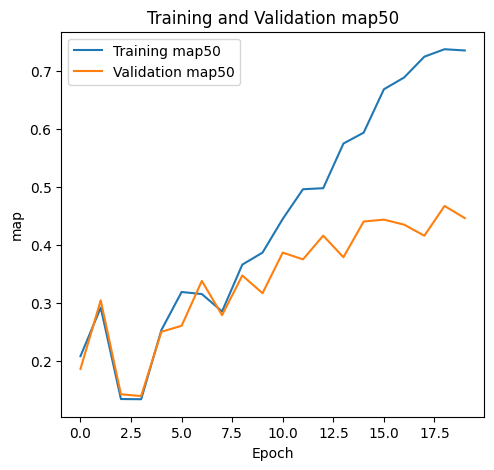

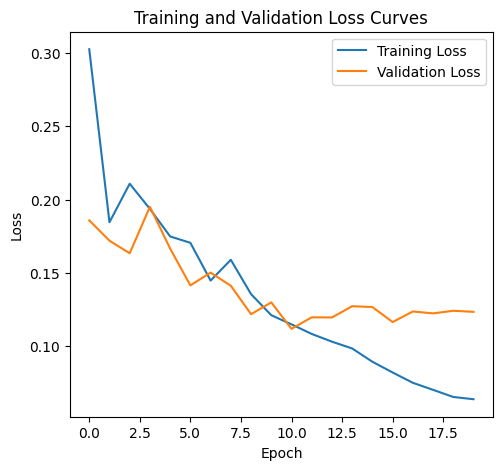

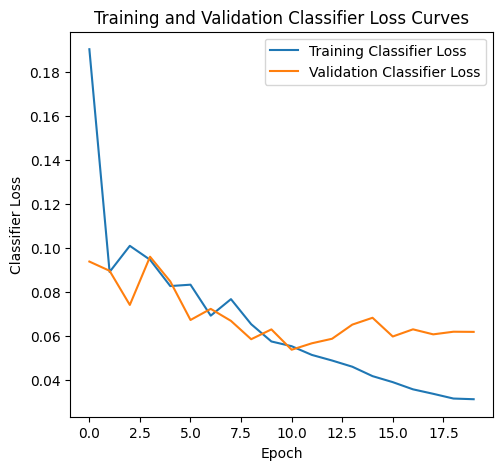

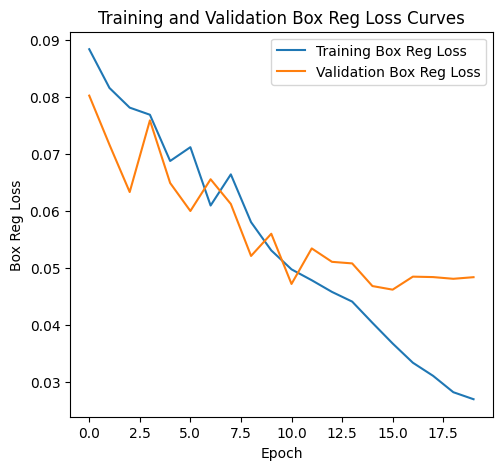

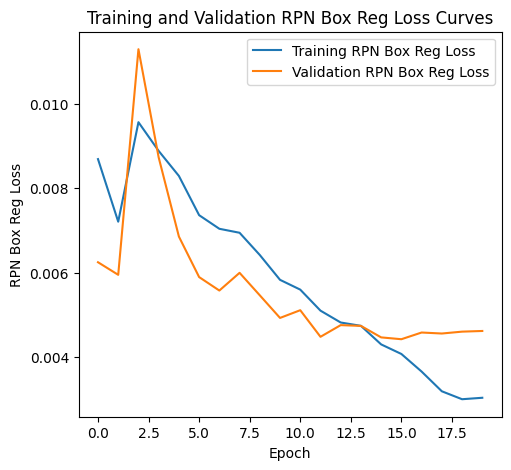

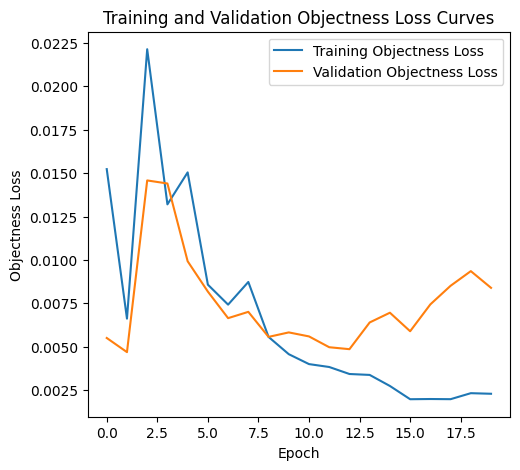

In [ ]:
## IMAGENET 3
if __name__ == "__main__":
    main()

In [ ]:
class MedInferenceDataset(Dataset):
    def __init__(self, root, transforms=None):
        """
        初始化資料集，只處理圖片檔案。

        :param root: 圖片資料夾路徑
        :param transforms: 圖片處理方法（可選）
        """
        self.root = root
        self.transforms = transforms
        self.image_files = sorted(
            [f for f in os.listdir(self.root) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        )

    def get_image(self, index):
        """
        讀取指定索引的圖片。

        :param index: 圖片索引
        :return: PIL 圖片物件
        """
        image_path = os.path.join(self.root, self.image_files[index])
        image = Image.open(image_path).convert("RGB")

        return image

    def __getitem__(self, index):
        image = self.get_image(index)
        #print(f"Fetching image at index: {index}")
        if self.transforms:
            image = self.transforms(image)

        target = {
            'boxes': torch.zeros((0, 4), dtype=torch.float32),  # 空的 bounding box
            'labels': torch.tensor([], dtype=torch.int64),      # 空的標籤
            'image_id': torch.tensor([index]),                 # 圖片 ID
            'size': image.shape[1:]  # 圖片原始尺寸 (高度, 寬度)
        }
        #'size': image.size[::-1],  # 圖片原始尺寸 (高度, 寬度)
        #'size': image.shape[1:]
        #print(f"Image{image}")
        #print(f"Target{target}")
        return image, target

    def __len__(self):
        """
        返回資料集中圖片的數量。
        """
        return len(self.image_files)

In [ ]:
def get_transform():

    transform = v2.Compose(
                [
                    v2.ToImage(), ## Used while using PIL image
                    #v2.ConvertBoundingBoxFormat(tv_tensors.BoundingBoxFormat.XYXY),
                    v2.ToDtype(torch.float32, scale=True),

                ])

    return transform

In [ ]:

def predict(input_tensor, model, device, detection_threshold):
    outputs = model(input_tensor)
    pred_classes = [config.categories[i] for i in outputs[0]['labels'].cpu().numpy()]
    pred_labels = outputs[0]['labels'].cpu().numpy()
    pred_scores = outputs[0]['scores'].detach().cpu().numpy()
    pred_bboxes = outputs[0]['boxes'].detach().cpu().numpy()

    boxes, classes, labels, indices,scores = [], [], [], [], []
    for index in range(len(pred_scores)):
        if pred_scores[index] >= detection_threshold:
            boxes.append(pred_bboxes[index].astype(np.int32))
            classes.append(pred_classes[index])
            labels.append(pred_labels[index])
            indices.append(index)
            scores.append(pred_scores[index])
    boxes = np.int32(boxes)

    return boxes, classes, labels, indices, scores

COLORS = np.random.uniform(0, 255, size=(len(config.categories), 3))

def draw_boxes(boxes, labels, classes, image):
    for i, box in enumerate(boxes):
        # Convert RGB to BGR for OpenCV
        color = COLORS[labels[i]].astype(int)[::-1]

        # Draw the bounding box
        cv2.rectangle(
            image,
            (int(box[0]), int(box[1])),
            (int(box[2]), int(box[3])),
            color.tolist(), 8
        )

        # Increase font size and thickness for label
        font_scale = 4 # Increase this value for larger font
        thickness = 10     # Increase thickness for better visibility

        # Add class label as text
        cv2.putText(image, classes[i],
                    (int(box[0]), int(box[1]) - 10),  # Adjust text position
                    cv2.FONT_HERSHEY_SIMPLEX,
                    font_scale,
                    color.tolist(),
                    thickness,
                    lineType=cv2.LINE_AA)
    return image


In [ ]:
def run_predictions(model, test_loader, device, detection_threshold):
    model.eval()
    all_predictions = []

    with torch.no_grad():
        for batch_idx, (images2, targets) in enumerate(test_loader):
                image_data = images2[0]
                input_tensor = image_data.unsqueeze(0).to(config.device)
                boxes, classes, labels, indices, scores = predict(
                    input_tensor, model, device, detection_threshold
                )

                target_dict = targets[0]
                img_id = target_dict["image_id"].item()
                img_size = target_dict["size"]

            # 取得圖片的寬度和高度
                img_height, img_width = img_size[0], img_size[1]

            # 正規化邊界框
                for j, box in enumerate(boxes):
                    xmin, ymin, xmax, ymax = box

                # 根據圖片的寬度和高度進行正規化
                    xmin_norm = xmin / img_width
                    ymin_norm = ymin / img_height
                    xmax_norm = xmax / img_width
                    ymax_norm = ymax / img_height

                # 存正規化後的預測結果
                    all_predictions.append({
                        "ID": img_id,
                        "category": classes[j],
                        "score": scores[j],
                        "xmin": xmin_norm,
                        "xmax": xmax_norm,
                        "ymin": ymin_norm,
                        "ymax": ymax_norm,
                    })

    return all_predictions


In [ ]:
# 測試資料集與 DataLoader
test_dataset = MedInferenceDataset(root=config.test_root, transforms=get_transform())
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False,num_workers=config.workers, collate_fn=collate_fn)
model = fasterrcnn(num_classes = config.num_classes)
state_dict = torch.load("/content/drive/MyDrive/working/final.pth")
model.load_state_dict(state_dict["model"])
model.to(config.device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
predictions = run_predictions(model, test_loader, config.device,0.5)
# 建立 DataFrame 並根據 test_ids 排序
results_df = pd.DataFrame(predictions)
results_df["ID"] = results_df["ID"].astype(int) + 1
results_df = results_df.sort_values(by="ID")
#results_df.head(10)

In [ ]:
test_csv_df = pd.read_csv('/content/drive/MyDrive/hwk05_data/test.csv')
test_csv_df['filename_id'] = test_csv_df['Filename'].str.extract(r'(\d+)').astype(int)

In [ ]:
merged_df = results_df.merge(test_csv_df[['filename_id', 'ID']], left_on='ID', right_on='filename_id', how='left')
# 可以刪除不再需要的欄位
merged_df = merged_df.drop(columns=['filename_id', 'ID_x'])
# 將 ID_y 移到第一列並將名稱更改為 ID
merged_df = merged_df.rename(columns={'ID_y': 'ID'})  # 重命名 ID_y 為 ID
# 將 ID 列移動到最前面
merged_df = merged_df[['ID'] + [col for col in merged_df.columns if col != 'ID']]
merged_df.head(10)

,ID,category,score,xmin,xmax,ymin,ymax
0,TDR02_20161123_145314,lung_field_infiltration,0.813216,0.083333,0.962199,0.055508,0.850000
1,TDR02_20161123_145314,cardiac_hypertrophy,0.780251,0.401203,0.858677,0.340678,0.783051
2,TDR02_20161123_145314,aortic_curvature,0.759652,0.383162,0.678265,0.214407,0.711864
3,TDR02_20161123_145314,aortic_atherosclerosis_calcification,0.668996,0.513746,0.665808,0.189831,0.404661
4,TDR01_20171106_111727,lung_field_infiltration,0.801966,0.061426,0.947165,0.050743,0.839934
5,TDR01_20171106_111727,degenerative_joint_disease_of_the_thoracic_spine,0.656470,0.365120,0.623711,0.059818,0.781766
6,TDR01_20180510_090210,lung_field_infiltration,0.732217,0.089721,0.918554,0.087582,0.860197
7,TDR01_20180510_090210,scoliosis,0.719673,0.407230,0.602787,0.243010,0.858964
8,TDR01_20180511_092549,scoliosis,0.844056,0.413880,0.597826,0.263199,0.730202
9,TDR01_20180511_092549,lung_field_infiltration,0.727985,0.075669,0.942726,0.076087,0.839674


In [ ]:
merged_df.tail(10)

,ID,category,score,xmin,xmax,ymin,ymax
217,TDR02_20161125_122319,scoliosis,0.935547,0.418416,0.609256,0.225610,0.806620
218,TDR02_20161125_122319,lung_field_infiltration,0.706930,0.093989,0.928435,0.060976,0.851481
219,TDR02_20180123_115426,lung_field_infiltration,0.743149,0.064583,0.929583,0.064072,0.902909
220,TDR02_20180123_115426,degenerative_joint_disease_of_the_thoracic_spine,0.617154,0.371667,0.613750,0.021226,0.840016
221,TDR01_20180508_173616,scoliosis,0.862198,0.393880,0.597005,0.181469,0.763158
222,TDR01_20180508_173616,lung_field_infiltration,0.561979,0.079427,0.918620,0.043860,0.847588
223,TDR01_20180508_173616,degenerative_joint_disease_of_the_thoracic_spine,0.577343,0.347005,0.634115,0.026316,0.875000
224,TDR02_20161118_145330,lung_field_infiltration,0.795087,0.076996,0.856464,0.069218,0.855456
225,TDR02_20161118_145330,aortic_curvature,0.717589,0.303232,0.609316,0.245521,0.647394
226,TDR02_20161118_145330,cardiac_hypertrophy,0.871938,0.328422,0.764259,0.311075,0.715391


In [ ]:
merged_df.shape

(227, 7)

In [ ]:
from google.colab import files
# 保存 CSV 文件到指定路徑
merged_df.to_csv('/content/AdamWOneCyclelr10-3_batch4.csv', index=False, header = True)
# 下載文件到本地機器
files.download('/content/AdamWOneCyclelr10-3_batch4.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
def plot_ablation_cam_images(transforms, model):

    rows, cols = 4, 2
    fig = plt.figure(figsize = (10, 20))
    grid = plt.GridSpec(rows, cols)
    best_ckpt = torch.load("/content/drive/MyDrive/working/final.pth", map_location = config.device)
    model.load_state_dict(best_ckpt["model"])
    model.eval().to(config.device)
    target_layers = [model.backbone]

    cam = AblationCAM(model,
                      target_layers,
                      reshape_transform = fasterrcnn_reshape_transform,
                      ablation_layer = AblationLayerFasterRCNN(),
                      ratio_channels_to_ablate = 1.0)

    for i in range(rows * cols):

        all_images = os.listdir(os.path.join(config.root, config.categories[i]))
        image_path = os.path.join(config.root, config.categories[i], all_images[0])
        image = Image.open(image_path).convert("RGB")
        input_tensor = transforms(image)
        input_tensor = input_tensor.to(config.device)
        input_tensor = input_tensor.unsqueeze(0)
        image = np.array(image)
        image_float_np = np.float32(image) / 255

        boxes, classes, labels, indices, scores = predict(input_tensor, model, config.device, 0.5)
        image = draw_boxes(boxes, labels, classes, image)
        targets = [FasterRCNNBoxScoreTarget(labels = labels, bounding_boxes = boxes)]

        grayscale_cam = cam(input_tensor, targets = targets)
        grayscale_cam = grayscale_cam[0, :]
        cam_image = show_cam_on_image(image_float_np, grayscale_cam, use_rgb = True)
        image_with_bounding_boxes = draw_boxes(boxes, labels, classes, cam_image)

        categories = fig.add_subplot(grid[i])
        categories.set_axis_off()

        gs = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec = grid[i])

        ax = fig.add_subplot(gs[0])
        ax.imshow(image_with_bounding_boxes)
        ax.set_title(f"{config.categories[i]}")
        ax.axis("off")

    fig.patch.set_facecolor('white')
    fig.suptitle("AblationCAM Images of 8 categories\n", fontweight = 'bold', size = 16)
    fig.tight_layout()

In [ ]:
plot_ablation_cam_images(transforms = get_transform(), model = fasterrcnn(config.num_classes))

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import os
from PIL import Image
from matplotlib.colors import ListedColormap
from matplotlib.colors import TABLEAU_COLORS

In [ ]:
def plot_image_with_boxes_test(df, test_csv_path, id_column, bbox_columns, image_dir):
    """
    Plots images with bounding boxes for each unique ID in the dataframe, with all boxes for the same ID on one image.

    Args:
        df (pd.DataFrame): DataFrame containing bounding box information.
        test_csv_path (str): Path to the test.csv file.
        id_column (str): Column name in df corresponding to the ID.
        bbox_columns (list of str): Column names for bounding box coordinates ["xmin", "xmax", "ymin", "ymax"].
        image_dir (str): Path to the directory containing processed test images.
        scale (float): Scale factor for resizing the image (0 < scale <= 1).
    """
    # Load test.csv
    test_csv = pd.read_csv("/content/drive/MyDrive/processed_images/test.csv")

    scale = 0.2
    unique_ids = df[id_column].unique()
    num_images = len(unique_ids)

    # Create subplots
    fig, axes = plt.subplots(
        nrows=(num_images + 2) // 3, ncols=3, figsize=(15, 5 * ((num_images + 2) // 3))
    )
    axes = axes.flatten()

    # Create a color map for categories
    categories = df['category'].unique()
    category_colors = {category: plt.cm.get_cmap('tab10')(i % 10) for i, category in enumerate(categories)}

    for ax, img_id in zip(axes, unique_ids):
        img_data = df[df[id_column] == img_id]

        # Find the corresponding dcm name in test.csv
        dcm_name = test_csv.loc[test_csv['ID'] == img_id, "Filename"].values[0]
        dcm_name = os.path.splitext(dcm_name)[0]

        # Construct the image path
        image_path = os.path.join(image_dir, f"{dcm_name}.jpg")

        # Check if the image file exists
        if not os.path.exists(image_path):
            ax.set_title(f"Image {dcm_name} not found.")
            ax.axis('off')
            continue

        # Open the image
        image = Image.open(image_path)
        width, height = image.size

        # Resize the image based on scale
        image = image.resize((int(width * scale), int(height * scale)))
        width, height = image.size

        # Plot the image
        ax.imshow(image)

        # Draw bounding boxes
        for i, row in img_data.iterrows():
            xmin, xmax, ymin, ymax = [row[col] for col in bbox_columns]
            bounding_width = (xmax - xmin) * width
            bounding_height = (ymax - ymin) * height

            # Get the color for the category
            category = row.get("category", "Unknown")
            color = category_colors.get(category, 'gray')  # Default to gray if category is not in the map

            rect = patches.Rectangle(
                (xmin * width, ymin * height),
                bounding_width,
                bounding_height,
                linewidth=2,
                edgecolor=color,
                facecolor='none'
            )
            ax.add_patch(rect)

            # Display the category text near the bounding box
            ax.text(
                xmin * width,
                ymin * height - 10,
                category,
                color='white',
                fontsize=8,
                bbox=dict(facecolor=color, alpha=0.5)
            )

        ax.set_title(f"ID: {img_id}")
        ax.axis('off')

    # Turn off any unused subplots
    for ax in axes[num_images:]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()


# Example usage
plot_image_with_boxes_test(merged_df[:10], "test.csv", "ID", ["xmin", "xmax", "ymin", "ymax"], "/content/drive/MyDrive/processed_images/test")
